In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.metrics import roc_curve, auc
from scipy.stats import loguniform, randint
from sklearn.base import BaseEstimator, TransformerMixin

df = pd.read_csv("ai_human_content_detection_dataset.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Params: {'clf__max_iter': 2000, 'clf__loss': 'hinge', 'clf__C': 3}
Best CV Accuracy: 0.5

Test Accuracy: 0.5912408759124088

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56        69
           1       0.58      0.66      0.62        68

    accuracy                           0.59       137
   macro avg       0.59      0.59      0.59       137
weighted avg       0.59      0.59      0.59       137



C:\Users\aceso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


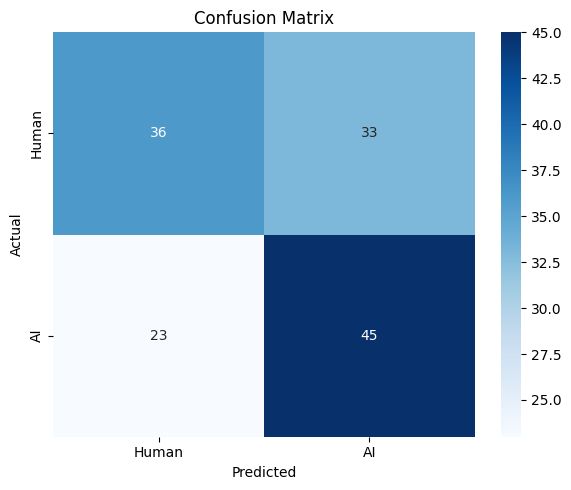


ROC-AUC: 0.6097612958226769


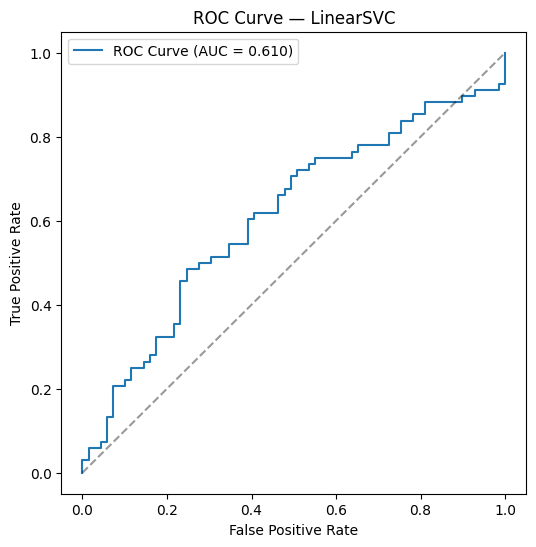

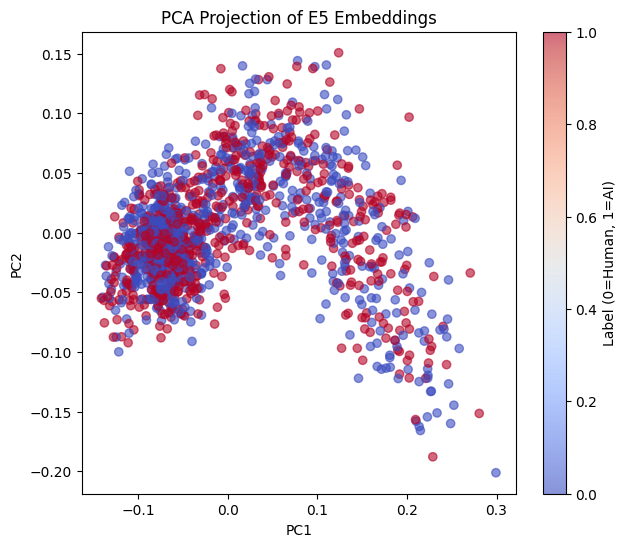

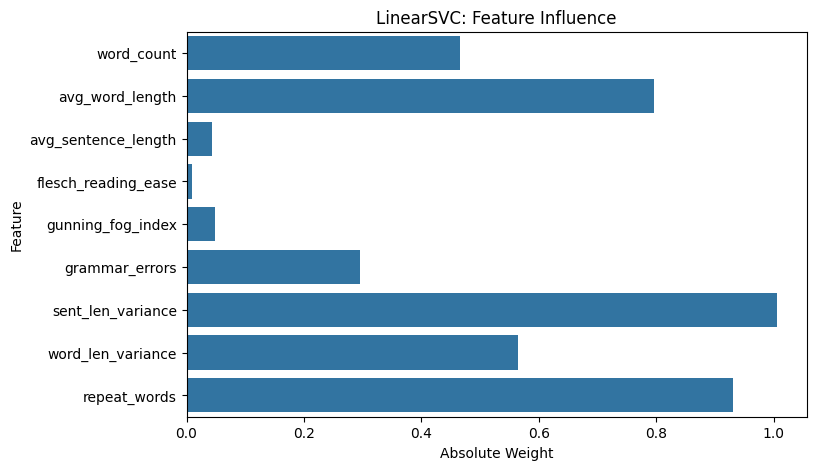

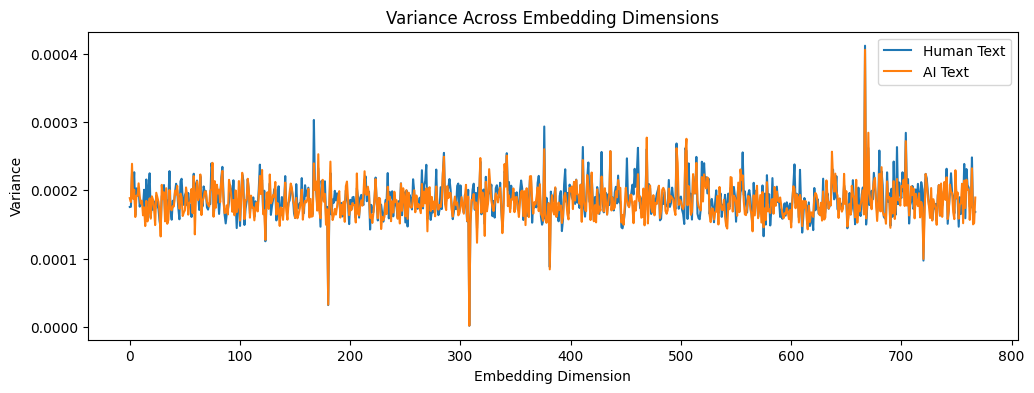

In [2]:
# Embedding function for raw text
class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model_name="intfloat/e5-base-v2", batch_size=32):
        self.model_name = model_name
        self.batch_size = batch_size
        self.model = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def fit(self, X, y=None):
        if self.model is None:
            self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    def transform(self, X):
        if hasattr(X, "iloc"):          
            X = X.iloc[:, 0] if X.ndim > 1 else X
        texts = X.astype(str).tolist()

        emb = self.model.encode(
            texts,
            batch_size=self.batch_size,
            show_progress_bar=False,
            device=self.device
        )
        return emb

# Early train-test split to prevent data leakage
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)

# Feature Engineering

# Sentence and word length variance
train_df["sent_len_variance"] = train_df["text_content"].apply(lambda t: np.var([len(s.split()) for s in t.split('.') if len(s.split())>0]))
train_df["word_len_variance"] = train_df["text_content"].apply(lambda t: np.var([len(w) for w in t.split()]) if len(t.split())>0 else 0)
test_df["sent_len_variance"] = test_df["text_content"].apply(lambda t: np.var([len(s.split()) for s in t.split('.') if len(s.split())>0]))
test_df["word_len_variance"] = test_df["text_content"].apply(lambda t: np.var([len(w) for w in t.split()]) if len(t.split())>0 else 0)

# Repeated words
def rep_ratio(text):
    words = text.lower().split()
    return len(words) - len(set(words))
train_df["repeat_words"] = train_df["text_content"].apply(rep_ratio)
test_df["repeat_words"] = test_df["text_content"].apply(rep_ratio)

# Model selection and pre-encoding for faster CV later down pipeline
model = SentenceTransformer("intfloat/e5-base-v2", device=device)
train_emb = model.encode(
    train_df["text_content"].astype(str).tolist(),
    batch_size=64,
    show_progress_bar=True,
)
test_emb = model.encode(
    test_df["text_content"].astype(str).tolist(),
    batch_size=64,
    show_progress_bar=True,
)

train_emb_df = pd.DataFrame(train_emb, columns=[f"emb_{i}" for i in range(train_emb.shape[1])])
test_emb_df = pd.DataFrame(test_emb, columns=[f"emb_{i}" for i in range(test_emb.shape[1])])

train_df = pd.concat([train_df.reset_index(drop=True), train_emb_df], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_emb_df], axis=1)

X_train = train_df.drop(columns=["label", "text_content"])
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "text_content"])
y_test = test_df["label"]


# Features
# Numeric features, including engineered features
numeric = [
    'word_count', 'avg_word_length', 'avg_sentence_length',
    'flesch_reading_ease', 'gunning_fog_index',
    'grammar_errors', 'punctuation_count', 'sent_len_variance', 'word_len_variance', 
    'repeat_words'
]

categorical = ['content_type']

# Ensure only existing columns are selected 
numeric = [col for col in numeric if col in X_train.columns]
categorical = [col for col in categorical if col in X_train.columns]
embedding_cols = [c for c in X_train.columns if c.startswith("emb_")]


# Imputer, Scaler, and One-Hot-Encoding 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# Embedding pipeline 
embedding_transformer = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
])


# Final pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical),
        ("emb", embedding_transformer, embedding_cols),
    ],
    remainder='drop'
)

# Model Definition
pipeline = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC())
])

# LinearSVC parameter distributions for use in the RandomizedSearchCV
param_dist = {
    "clf__C": [1e-4, 3e-4, 1e-3, 3e-3, 1e-2,
          3e-2, 1e-1, 3e-1, 1, 3,
          10, 30, 100],
    "clf__loss": ["hinge", "squared_hinge"],
    "clf__max_iter": [2000, 5000, 8000]
}
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
    random_state=42,
)


search.fit(X_train, y_train)

# CV Accuracy print
print("\nBest Params:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Test accuracy print
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plots and Data
# Every run seems to have a different accuracy, ranging from 0.58 to 0.63. We believe this is because of the 
# train/test shuffle in combination with the embedding transformer.

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

y_scores = best_model.decision_function(X_test)

roc_auc = roc_auc_score(y_test, y_scores)
print("\nROC-AUC:", roc_auc)

# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LinearSVC")
plt.legend()
plt.show()



# PCA Plot
pca = PCA(n_components=2)
xy = pca.fit_transform(np.vstack((train_emb, test_emb)))

labels_all = np.concatenate([y_train, y_test])

plt.figure(figsize=(7,6))
plt.scatter(xy[:,0], xy[:,1], c=labels_all, cmap="coolwarm", alpha=0.6)
plt.title("PCA Projection of E5 Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Label (0=Human, 1=AI)")
plt.show()



# Importance Plot
feature_names = numeric 
coef = np.abs(best_model.named_steps["clf"].coef_[0][:len(feature_names)])

plt.figure(figsize=(8,5))
sns.barplot(x=coef, y=feature_names)
plt.title("LinearSVC: Feature Influence")
plt.xlabel("Absolute Weight")
plt.ylabel("Feature")
plt.show()

# Embedding Variance
human_emb = train_emb[y_train == 0]
ai_emb = train_emb[y_train == 1]

plt.figure(figsize=(12,4))
plt.plot(human_emb.var(axis=0), label="Human Text")
plt.plot(ai_emb.var(axis=0), label="AI Text")
plt.title("Variance Across Embedding Dimensions")
plt.xlabel("Embedding Dimension")
plt.ylabel("Variance")
plt.legend()
plt.show()
